In [ ]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image, ImageFile
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras import optimizers


Using TensorFlow backend.


In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip


Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:02, 51.9MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
np.random.seed(232)
tf.random.set_seed(232)

sdbgfiugsdif
shdiufhsd

In [ ]:
input_path = '/content/two/'

In [ ]:
train_dir = os.path.join(input_path,'train')
test_dir = os.path.join(input_path,'test')

In [ ]:
train_normal_dir = os.path.join(train_dir,'normal')
train_covid_dir = os.path.join(train_dir,'covid')
test_normal_dir = os.path.join(test_dir,'normal')
test_covid_dir = os.path.join(test_dir,'covid')

In [ ]:
num_covid_tr = len(os.listdir(train_covid_dir))
print('Covid training examples are :', num_covid_tr)

Covid training examples are : 60


In [ ]:
batch_size = 14
epochs = 500
img_dims= 150
LEARNING_RATE =0.05 


In [ ]:
 train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=50,
 #featurewise_center = True,
 #featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2,
 )
train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)   

valid_batches = train_datagen.flow_from_directory(
 directory=train_dir,
 target_size=(img_dims,img_dims),
 shuffle=True,
 batch_size=batch_size,
 subset = 'validation',
 seed=42,
 class_mode='binary',
 )

Found 130 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [ ]:
test_val_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

Found 18 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_gen)


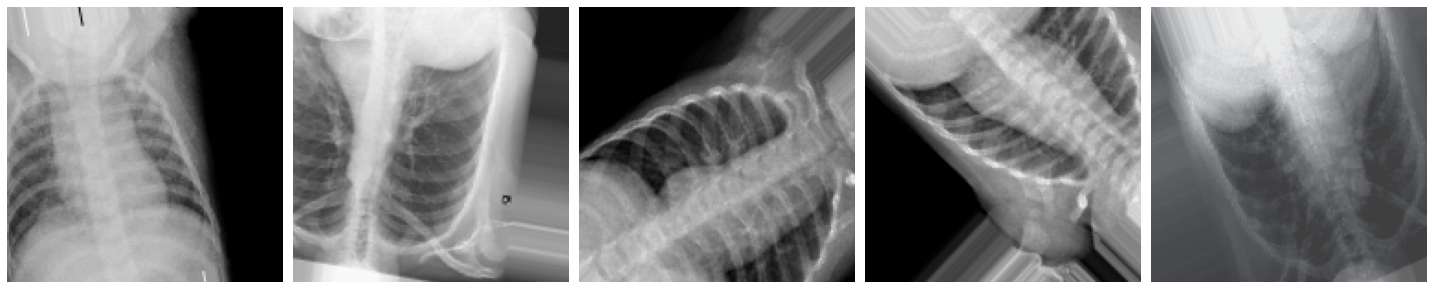

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip( sample_training_images[:5], axes):
    ax.imshow(img)

    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from keras.applications import VGG16
from keras.layers.core import Flatten, Dense, Dropout, Lambda


conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3),pooling='max')
conv_base.trainable = False
conv_base.summary()

model = Sequential()
for layer in conv_base.layers[:-1]: # go through until last layer
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False
model.summary()
        


58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:

          

model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())


model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
sgd =Adam(lr=0.0082, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=valid_batches, 
           validation_steps=test_gen.samples )

Epoch 1/500
9/9 [==============================] - 16s 2s/step - loss: 0.6780 - acc: 0.5517 - val_loss: 0.7035 - val_acc: 0.5385
Epoch 2/500
9/9 [==============================] - 10s 1s/step - loss: 0.3547 - acc: 0.8651 - val_loss: 0.7221 - val_acc: 0.4615
Epoch 3/500
9/9 [==============================] - 10s 1s/step - loss: 0.3230 - acc: 0.9151 - val_loss: 0.7901 - val_acc: 0.4615
Epoch 4/500
9/9 [==============================] - 10s 1s/step - loss: 0.3676 - acc: 0.8492 - val_loss: 0.6462 - val_acc: 0.9359
Epoch 5/500
9/9 [==============================] - 9s 1s/step - loss: 0.1916 - acc: 0.9483 - val_loss: 0.5768 - val_acc: 0.9060
Epoch 6/500
9/9 [==============================] - 9s 1s/step - loss: 0.1804 - acc: 0.9655 - val_loss: 0.4618 - val_acc: 0.9145
Epoch 7/500
9/9 [==============================] - 9s 1s/step - loss: 0.1854 - acc: 0.9397 - val_loss: 0.4727 - val_acc: 0.6026
Epoch 8/500
9/9 [==============================] - 9s 983ms/step - loss: 0.2796 - acc: 0.8879 - val_

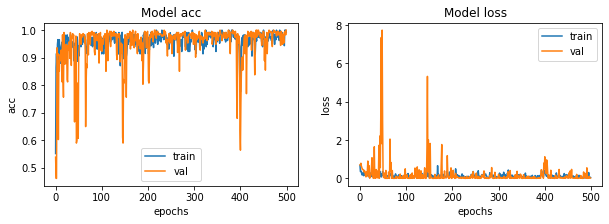

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc','loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_data = []
test_labels = []

for cond in ['/normal/', '/covid/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        #img = cv2.resize(img, (img_dims, img_dims))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        img = np.array(img)
        if cond=='/normal/':
            label = 0
        elif cond=='/covid/':
            label = 1
        test_data.append(img)
        test_labels.append(label)
        
test_labels = np.array(test_labels)
    

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_gen)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[5 4]
 [5 4]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall: 44.44444444444444%
F1-score: 47.05882352941176

TRAIN METRIC ----------------------
Train acc: 99.21


In [ ]:
scores = model.evaluate_generator(test_gen)
print("%s: %.2f%%" %(model.metrics_names[1],scores[1]*100))

acc: 94.44%


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                      
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()

In [ ]:
# download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1BKtGlrbWyI4A__Mary3pPfSPyjbc6lB7'})

In [ ]:
file_obj = drive.CreateFile({'id': '1BKtGlrbWyI4A__Mary3pPfSPyjbc6lB7'})                      
file_obj.GetContentFile('model.h5')

In [ ]:
from keras.models import load_model
new_model=load_model(model.h5)
new_model.summary()

NameError: ignored

ValueError: ignored

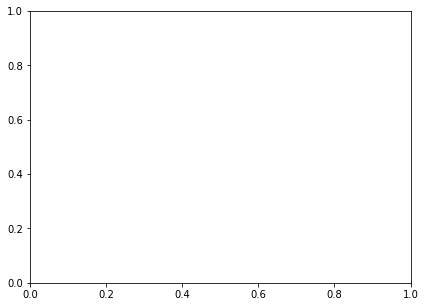

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(result, epochs):
    acc = hist.history['acc']
    loss = hist.history['loss']
    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ‘' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss’)')
    plt.title('Loss over' + str(epochs) + 'Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_acc_loss(hist, 20)

In [ ]:
model.save('first6.h5')